# 第6章: 英語テキストの処理
英語のテキスト（nlp.txt）に対して，以下の処理を実行せよ．

In [1]:
!head -10 ../data/nlp.txt

Natural language processing
From Wikipedia, the free encyclopedia

Natural language processing (NLP) is a field of computer science, artificial intelligence, and linguistics concerned with the interactions between computers and human (natural) languages. As such, NLP is related to the area of humani-computer interaction. Many challenges in NLP involve natural language understanding, that is, enabling computers to derive meaning from human or natural language input, and others involve natural language generation.

History

The history of NLP generally starts in the 1950s, although work can be found from earlier periods. In 1950, Alan Turing published an article titled "Computing Machinery and Intelligence" which proposed what is now called the Turing test as a criterion of intelligence.

The Georgetown experiment in 1954 involved fully automatic translation of more than sixty Russian sentences into English. The authors claimed that within three or five years, machine translation would b

## 50. 文区切り
(. or ; or : or ? or !) → 空白文字 → 英大文字というパターンを文の区切りと見なし，入力された文書を1行1文の形式で出力せよ．

In [2]:
import re
from itertools import islice

def gen_sentence_nlptxt():
    eng_eos = re.compile('([\.|;|:|?|!|\n])\s+([A-Z])')
    with open('../data/nlp.txt') as f:
        for line in f:
            sentences = eng_eos.sub(r'\g<1>\n\g<2>', line)
            for sentence in sentences.split('\n'):
                if sentence:
                    yield sentence

for sentence in islice(gen_sentence_nlptxt(), 20):
    print(sentence)  

Natural language processing
From Wikipedia, the free encyclopedia
Natural language processing (NLP) is a field of computer science, artificial intelligence, and linguistics concerned with the interactions between computers and human (natural) languages.
As such, NLP is related to the area of humani-computer interaction.
Many challenges in NLP involve natural language understanding, that is, enabling computers to derive meaning from human or natural language input, and others involve natural language generation.
History
The history of NLP generally starts in the 1950s, although work can be found from earlier periods.
In 1950, Alan Turing published an article titled "Computing Machinery and Intelligence" which proposed what is now called the Turing test as a criterion of intelligence.
The Georgetown experiment in 1954 involved fully automatic translation of more than sixty Russian sentences into English.
The authors claimed that within three or five years, machine translation would be a 

## 51. 単語の切り出し
空白を単語の区切りとみなし，50の出力を入力として受け取り，1行1単語の形式で出力せよ．ただし，文の終端では空行を出力せよ．

In [3]:
from itertools import islice

def gen_word(senrence_generator):
    for sentence in senrence_generator:
        words = sentence.split(' ')
        for i, word in enumerate(words):
            # 文中と文末で削除する記号を変える
            if i != len(words) - 1:
                # 文中の .（ピリオド） は省略表記のケースがあるため、文中単語の場合は . は削除しない
                yield word.strip(',:;()\'"-?!')
            else:   
                yield word.strip('.,:;()\'"-?!')
        yield ''

for word in islice(gen_word(gen_sentence_nlptxt()), 46):
    print(word)

Natural
language
processing

From
Wikipedia
the
free
encyclopedia

Natural
language
processing
NLP
is
a
field
of
computer
science
artificial
intelligence
and
linguistics
concerned
with
the
interactions
between
computers
and
human
natural
languages

As
such
NLP
is
related
to
the
area
of
humani-computer
interaction


## 52. ステミング
51の出力を入力として受け取り，Porterのステミングアルゴリズムを適用し，単語と語幹をタブ区切り形式で出力せよ． Pythonでは，Porterのステミングアルゴリズムの実装としてstemmingモジュールを利用するとよい．

In [4]:
from stemming.porter2 import stem
from itertools import islice

for word in islice(gen_word(gen_sentence_nlptxt()), 46):
    print(word + '\t' + stem(word))

Natural	Natur
language	languag
processing	process
	
From	From
Wikipedia	Wikipedia
the	the
free	free
encyclopedia	encyclopedia
	
Natural	Natur
language	languag
processing	process
NLP	NLP
is	is
a	a
field	field
of	of
computer	comput
science	scienc
artificial	artifici
intelligence	intellig
and	and
linguistics	linguist
concerned	concern
with	with
the	the
interactions	interact
between	between
computers	comput
and	and
human	human
natural	natur
languages	languag
	
As	As
such	such
NLP	NLP
is	is
related	relat
to	to
the	the
area	area
of	of
humani-computer	humani-comput
interaction	interact


## 53. Tokenization
Stanford Core NLPを用い，入力テキストの解析結果をXML形式で得よ．また，このXMLファイルを読み込み，入力テキストを1行1単語の形式で出力せよ．

In [5]:
'''
Annotatorsの説明
https://stanfordnlp.github.io/CoreNLP/annotators.html

依存関係
https://stanfordnlp.github.io/CoreNLP/dependencies.html

以下のコマンドを実行
/usr/local/lib/stanford-corenlp-full-2018-02-27/corenlp.sh -annotators tokenize,ssplit,pos,lemma,ner,parse,dcoref -file ../data/nlp.txt -outputDirectory ../work -outputFormat xml
'''
! head -n 30 ../work/nlp.txt.xml

In [6]:
from itertools import islice
import xml.etree.ElementTree as ET
            
def knock_53_parse():
    tree = ET.parse('../work/nlp.txt.xml')
    for elem in tree.iterfind('document/sentences/sentence/tokens/token/word'):
        yield elem.text

def knock_53_iterparse():
    with open('../work/nlp.txt.xml') as f:
        # 以下を参考にインクリメンタルにXMLをパースする
        # http://effbot.org/zone/element-iterparse.htm#incremental-parsing
        context = ET.iterparse(f, events=('start', 'end'))
        context = iter(context)
        event, root = next(context)
        for event, elem in context:
            if event == 'end' and elem.tag == 'word':
                yield elem.text
            root.clear()

for word in islice(knock_53_iterparse(), 30):
    print(word)

list_a = [a for a in knock_53_parse()]
list_b = [b for b in knock_53_iterparse()]
assert list_a == list_b, 'There is difference between "parse" and "iterparse".'

Natural
language
processing
From
Wikipedia
,
the
free
encyclopedia
Natural
language
processing
-LRB-
NLP
-RRB-
is
a
field
of
computer
science
,
artificial
intelligence
,
and
linguistics
concerned
with
the


## 54. 品詞タグ付け
Stanford Core NLPの解析結果XMLを読み込み，単語，レンマ，品詞をタブ区切り形式で出力せよ．

In [7]:
from itertools import islice
import xml.etree.ElementTree as ET

def knock_54_parse():
    tree = ET.parse('../work/nlp.txt.xml')
    tag_set = {'word', 'lemma', 'POS'}
    for elem in tree.iterfind('document/sentences/sentence/tokens/token'):
        yield {tag:elem.findtext(tag) for tag in tag_set}
    
def knock_54_iterparse():
    with open('../work/nlp.txt.xml') as f:
        word_info = {}
        tag_set = {'word', 'lemma', 'POS'}
        context = ET.iterparse(f, events=('start', 'end'))
        context = iter(context)
        event, root = next(context)
        for event, elem in context:
            if event == 'start' and elem.tag == 'token':
                word_info.clear()
            elif event == 'end':
                if elem.tag in tag_set:
                    word_info[elem.tag] = elem.text
                elif elem.tag == 'token':
                    yield dict(word_info)
            root.clear()
        
for word_info in islice(knock_54_iterparse(), 30):
    print(word_info['word'] + '\t' + word_info['lemma'] + '\t' + word_info['POS'])
    
list_a = [a for a in knock_54_parse()]
list_b = [b for b in knock_54_iterparse()]
assert list_a == list_b, 'There is difference between "parse" and "iterparse".'

Natural	natural	JJ
language	language	NN
processing	processing	NN
From	from	IN
Wikipedia	Wikipedia	NNP
,	,	,
the	the	DT
free	free	JJ
encyclopedia	encyclopedia	NN
Natural	natural	JJ
language	language	NN
processing	processing	NN
-LRB-	-lrb-	-LRB-
NLP	nlp	NN
-RRB-	-rrb-	-RRB-
is	be	VBZ
a	a	DT
field	field	NN
of	of	IN
computer	computer	NN
science	science	NN
,	,	,
artificial	artificial	JJ
intelligence	intelligence	NN
,	,	,
and	and	CC
linguistics	linguistics	NNS
concerned	concern	VBN
with	with	IN
the	the	DT


## 55. 固有表現抽出
入力文中の人名をすべて抜き出せ．

In [8]:
import xml.etree.ElementTree as ET

def knock_55_parse():
    tree = ET.parse('../work/nlp.txt.xml')
    tag_set = {'word', 'NER'}
    for elem in tree.iterfind('document/sentences/sentence/tokens/token[NER="PERSON"]'):
        yield {tag:elem.findtext(tag) for tag in tag_set}

def knock_55_iterparse():
    with open('../work/nlp.txt.xml') as f:
        word_info = {}
        tag_set = {'word', 'NER'}
        context = ET.iterparse(f, events=('start', 'end'))
        context = iter(context)
        event, root = next(context)
        word_info = {}
        for event, elem in context:
            if event == 'start' and elem.tag == 'token':
                word_info.clear()
            elif event == 'end':
                if elem.tag in tag_set:
                    word_info[elem.tag] = elem.text
                elif elem.tag == 'token' and word_info['NER'] == 'PERSON':
                    yield dict(word_info)
            root.clear()
        
for word_info in knock_55_iterparse():
    print(word_info['word'])
    
list_a = [a for a in knock_55_parse()]
list_b = [b for b in knock_55_iterparse()]
assert list_a == list_b, 'There is difference between "parse" and "iterparse".'

Alan
Turing
Joseph
Weizenbaum
MARGIE
Schank
Wilensky
Meehan
Lehnert
Carbonell
Lehnert
Racter
Jabberwacky
Moore


## 56. 共参照解析
Stanford Core NLPの共参照解析の結果に基づき，文中の参照表現（mention）を代表参照表現（representative mention）に置換せよ．ただし，置換するときは，「代表参照表現（参照表現）」のように，元の参照表現が分かるように配慮せよ．

In [9]:
import xml.etree.ElementTree as ET
from collections import defaultdict
from itertools import islice

def knock_56():
    
    def parse_coreference(core_nlp_tree):
        coreference = defaultdict(tuple)
        for elem in core_nlp_tree.iterfind('document/coreference/coreference/mention'):
            if elem.get('representative') == 'true':
                representative_mention = elem.findtext('text')
                continue
            sent_id = int(elem.findtext('sentence'))
            begin = int(elem.findtext('start'))
            end = int(elem.findtext('end'))
            mention = elem.findtext('text')
            # 文中のある単語に複数の代表参照表現がある場合、より長い表現を優先する
            if (sent_id, begin) in coreference:
                existing_end, _, _ = coreference[(sent_id, begin)]
                if end < existing_end:
                    continue
            coreference[(sent_id, begin)] = (end, mention, representative_mention)
        return coreference
    
    def gen_sentence_resolved_coref(core_nlp_tree, coreference):
        for sentence_elem in core_nlp_tree.iterfind('document/sentences/sentence'):
            sent_id = int(sentence_elem.get('id'))
            sentence = ''
            end = -1
            for token in sentence_elem.iterfind('tokens/token'):
                token_id = int(token.get('id'))
                if (sent_id, token_id) in coreference:
                    end, _, representative_mention = coreference[(sent_id, token_id)]
                    sentence += representative_mention + ' ( '
                sentence += token.findtext('word') + ' ' if (token_id != end - 1) else token.findtext('word') + ' ) '
            yield sentence
            sentence = ''
        
    core_nlp_tree = ET.parse('../work/nlp.txt.xml')
    coreference = parse_coreference(core_nlp_tree)
    return gen_sentence_resolved_coref(core_nlp_tree, coreference)
            
for sentence in islice(knock_56(), 10):
    print(sentence)

Natural language processing From Wikipedia , the free encyclopedia Natural language processing -LRB- NLP -RRB- is the free encyclopedia Natural language processing -LRB- NLP -RRB- ( a field of computer science ) , artificial intelligence , and linguistics concerned with the interactions between computers and human -LRB- natural -RRB- languages . 
As such , NLP is related to the area of humani-computer interaction . 
Many challenges in NLP involve natural language understanding , that is , enabling computers ( computers ) to derive meaning from human or natural language input , and others involve natural language generation . 
History The history of NLP generally starts in the 1950s , although work can be found from earlier periods . 
In 1950 , Alan Turing published an article titled `` Computing Machinery and Intelligence '' which proposed what is now called the Alan Turing ( Turing ) test as a criterion of intelligence . 
The Georgetown experiment in 1954 involved fully automatic tran

## 57. 係り受け解析
Stanford Core NLPの係り受け解析の結果（collapsed-dependencies）を有向グラフとして可視化せよ．可視化には，係り受け木をDOT言語に変換し，Graphvizを用いるとよい．また，Pythonから有向グラフを直接的に可視化するには，pydotを使うとよい．

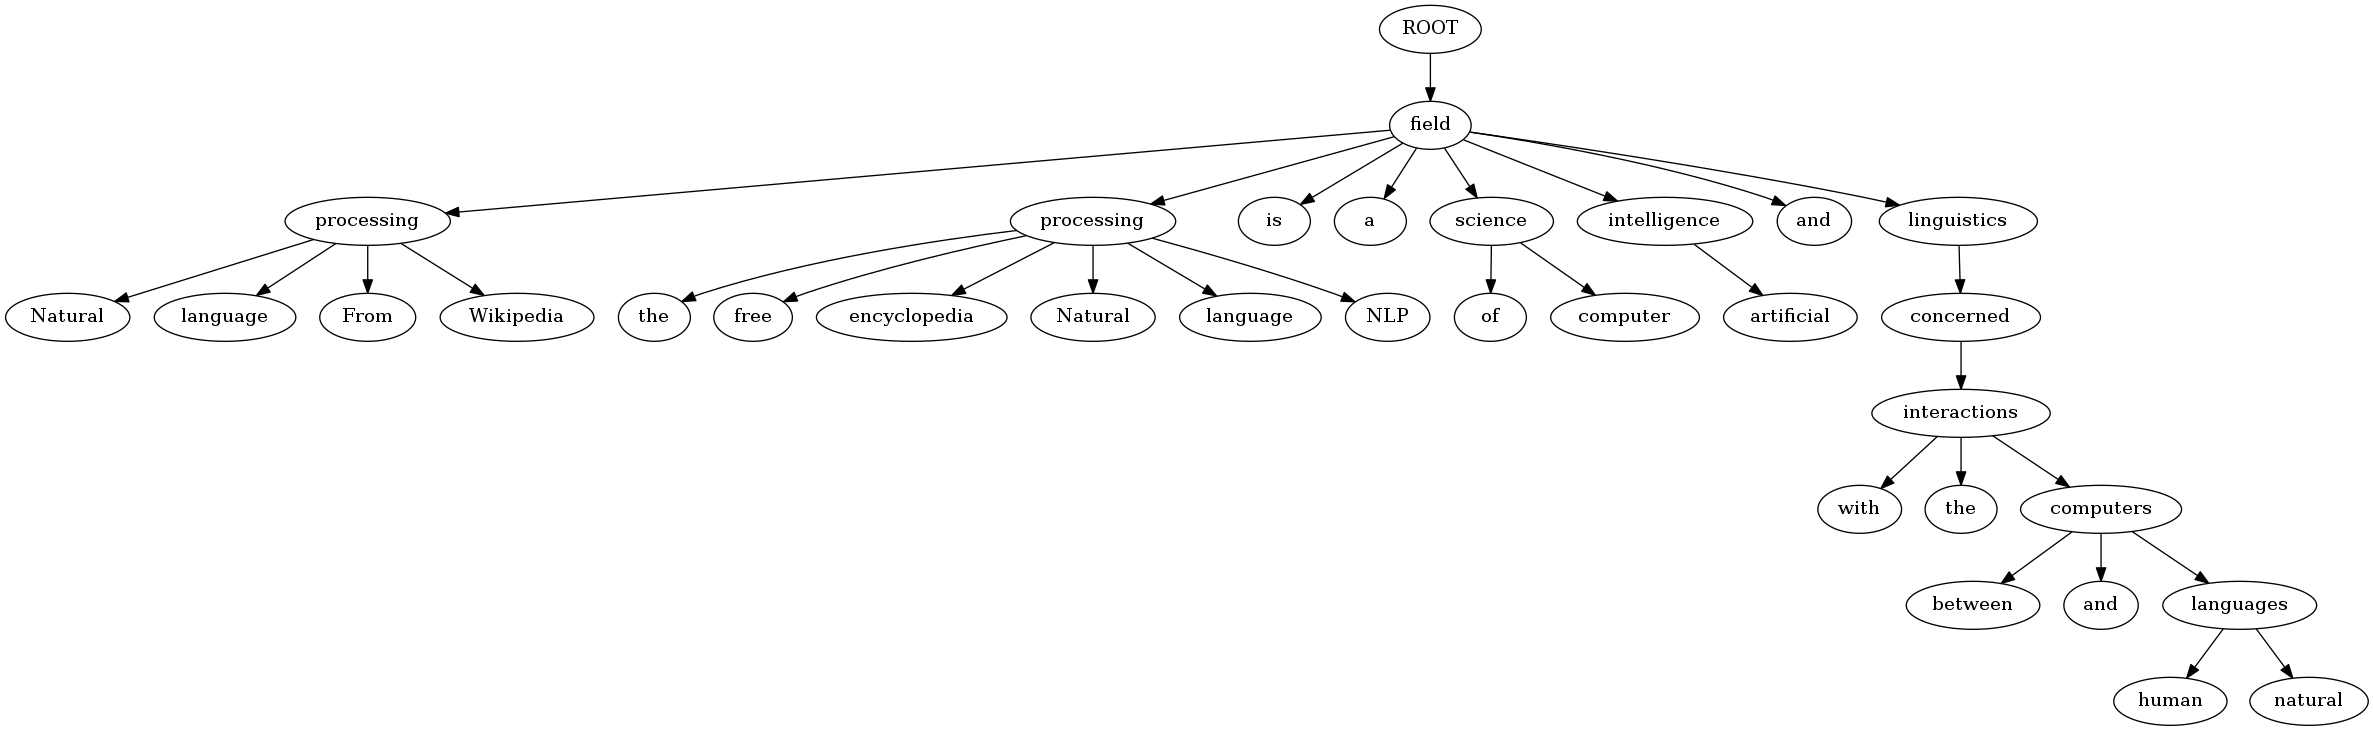

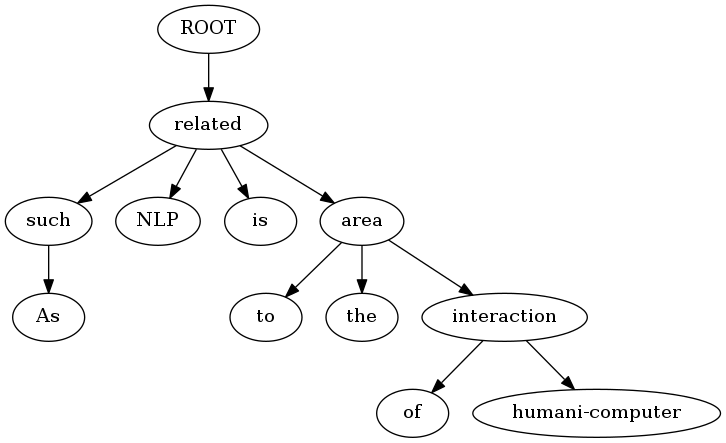

In [10]:
import pydot
from IPython.display import Image, display

def knock_57():
    core_nlp_tree = ET.parse('../work/nlp.txt.xml')
    display_counts = 0
    for dependencies in core_nlp_tree.iterfind('document/sentences/sentence/dependencies[@type="collapsed-dependencies"]'):
        graph = pydot.Dot(graph_type='digraph')
        for depnedency in dependencies:
            if depnedency.get('type') == 'punct':
                # "," を入れるとpydotでAssertionErrorが発生するため、句読点は除外する
                continue
                
            governor_idx = depnedency.find('governor').get('idx')
            governor_text = depnedency.find('governor').text
            dependent_idx = depnedency.find('dependent').get('idx')
            dependent_text = depnedency.find('dependent').text

            graph.add_node(pydot.Node(governor_idx, label=governor_text))
            graph.add_node(pydot.Node(dependent_idx, label=dependent_text))
            graph.add_edge(pydot.Edge(governor_idx, dependent_idx))

        plt = Image(graph.create_png())
        display(plt)
        display_counts += 1

        if display_counts >= 2:
            break
            
knock_57()

## 58. タプルの抽出
Stanford Core NLPの係り受け解析の結果（collapsed-dependencies）に基づき，「主語 述語 目的語」の組をタブ区切り形式で出力せよ．ただし，主語，述語，目的語の定義は以下を参考にせよ．

- 述語: nsubj関係とdobj関係の子（dependant）を持つ単語
- 主語: 述語からnsubj関係にある子（dependent）
- 目的語: 述語からdobj関係にある子（dependent）

In [11]:
from collections import defaultdict

def knock_58():
    core_nlp_tree = ET.parse('../work/nlp.txt.xml')
    for dependencies in core_nlp_tree.iterfind('document/sentences/sentence/dependencies[@type="collapsed-dependencies"]'):
        id_word_pair = {}  # key:id, value:単語のテキスト 
        parent_dependent_nsubj = defaultdict(list)  # key:parentのid, value:nsubj関係にある子のテキストのリスト
        parent_dependent_dobj = defaultdict(list)  # key:parentのid, value:dobj関係にある子のテキストのリスト
        for dependency in dependencies:
            dep_type = dependency.get('type')
            governor_idx = dependency.find('governor').get('idx')
            governor_text = dependency.find('governor').text
            dependent_text = dependency.find('dependent').text
            dependent_idx = dependency.find('dependent').get('idx')
            
            if dep_type == 'nsubj':
                id_word_pair[governor_idx] = governor_text
                parent_dependent_nsubj[governor_idx].append(dependent_text)
            elif dep_type == 'dobj':
                id_word_pair[governor_idx] = governor_text
                parent_dependent_dobj[governor_idx].append(dependent_text)
                
        verb_ids = parent_dependent_nsubj.keys() & parent_dependent_dobj.keys()
        for verb_id in verb_ids:
            for nsubj in parent_dependent_nsubj[verb_id]:
                for dobj in parent_dependent_dobj[verb_id]:               
                    yield nsubj + '\t' + id_word_pair[verb_id] + '\t' + dobj
    
for svo in knock_58():
    print(svo)

others	involve	generation
understanding	enabling	computers
Turing	published	article
experiment	involved	translation
ELIZA	provided	interaction
patient	exceeded	base
ELIZA	provide	response
which	structured	information
that	underlies	approach
underpinnings	discouraged	sort
Some	produced	systems
which	make	decisions
systems	rely	which
that	contains	errors
implementations	involved	coding
algorithms	take	set
Some	produced	systems
which	make	decisions
they	express	certainty
models	have	advantage
Systems	have	advantages
Automatic	make	use
that	make	decisions


## 59. S式の解析
Stanford Core NLPの句構造解析の結果（S式）を読み込み，文中のすべての名詞句（NP）を表示せよ．入れ子になっている名詞句もすべて表示すること．

In [12]:
import re

def knock_59():
    
    def extract_np(text):
        pattern = '\((.*?) (.*)\)'
        prog = re.compile(pattern)
        result = prog.search(text)
        phrase = result.group(1)  # スペースで区切られた式の左側の情報（SやNP、VPなど）
        expression = result.group(2)  # スペースで区切られた式の右側の情報（単語や入れ子の式）
        
        constituent = ''
        depth = 0
        words = []
        if expression.startswith('('):
            # 入れ子の式がある場合
            for c in expression:
                if c == '(':
                    depth += 1
                    constituent += c
                elif c == ')':
                    depth -= 1
                    constituent += c
                    if depth == 0:
                        # 括弧の対応が取れた時点で再帰的に解析する
                        words.append(extract_np(constituent))
                        constituent = ''
                else:
                    constituent += c
        else:
            # 入れ子の式がない場合
            words.append(expression)
            
        if phrase == 'NP':
            print(' '.join(words).rstrip())

        return ' '.join(words).rstrip()          

    core_nlp_tree = ET.parse('../work/nlp.txt.xml')
    for parse in core_nlp_tree.iterfind('document/sentences/sentence/parse'):
        extract_np(parse.text)

knock_59()

Natural language processing
Wikipedia
the free encyclopedia Natural language processing
NLP
the free encyclopedia Natural language processing -LRB- NLP -RRB-
a field
computer science
a field of computer science
artificial intelligence
linguistics
the interactions
computers
human -LRB- natural -RRB- languages
computers and human -LRB- natural -RRB- languages
the interactions between computers and human -LRB- natural -RRB- languages
linguistics concerned with the interactions between computers and human -LRB- natural -RRB- languages
a field of computer science , artificial intelligence , and linguistics concerned with the interactions between computers and human -LRB- natural -RRB- languages
such
NLP
the area
humani-computer interaction
the area of humani-computer interaction
Many challenges
NLP
Many challenges in NLP
natural language understanding
natural language understanding , that is ,
computers
meaning
human or natural language input
others
natural language generation
History The h